In [122]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [123]:
weather_data = pd.read_csv('weather_classification_data.csv')

In [124]:
weather_data = weather_data[['Temperature', 'Humidity', 'Atmospheric Pressure', 'Cloud Cover', 'Weather Type']]
weather_data

,Temperature,Humidity,Atmospheric Pressure,Cloud Cover,Weather Type
0,14.0,73,1010.82,partly cloudy,Rainy
1,39.0,96,1011.43,partly cloudy,Cloudy
2,30.0,64,1018.72,clear,Sunny
3,38.0,83,1026.25,clear,Sunny
4,27.0,74,990.67,overcast,Rainy
...,...,...,...,...,...
13195,10.0,74,1003.15,overcast,Rainy
13196,-1.0,76,1067.23,cloudy,Snowy
13197,30.0,77,1012.69,overcast,Cloudy
13198,3.0,76,984.27,overcast,Snowy


In [125]:
weather_data.value_counts(['Cloud Cover'])

Cloud Cover  
overcast         6090
partly cloudy    4560
clear            2139
cloudy            411
Name: count, dtype: int64

In [126]:
weather_data['Cloud Cover'] = weather_data['Cloud Cover'].apply(lambda data: np.random.normal(92.5, 3) if data == 'clear' else
                                                               np.random.normal(78, 4) if data == 'partly cloudy' else
                                                               np.random.normal(60, 5) if data == 'cloudy' else
                                                               np.random.normal(25, 8) if data == 'overcast' else data)

weather_data.rename(columns={'Cloud Cover': 'Light Level'}, inplace=True)
weather_data

,Temperature,Humidity,Atmospheric Pressure,Light Level,Weather Type
0,14.0,73,1010.82,80.084569,Rainy
1,39.0,96,1011.43,76.375863,Cloudy
2,30.0,64,1018.72,89.876201,Sunny
3,38.0,83,1026.25,95.673027,Sunny
4,27.0,74,990.67,27.499298,Rainy
...,...,...,...,...,...
13195,10.0,74,1003.15,15.292326,Rainy
13196,-1.0,76,1067.23,61.377856,Snowy
13197,30.0,77,1012.69,20.834797,Cloudy
13198,3.0,76,984.27,18.083548,Snowy


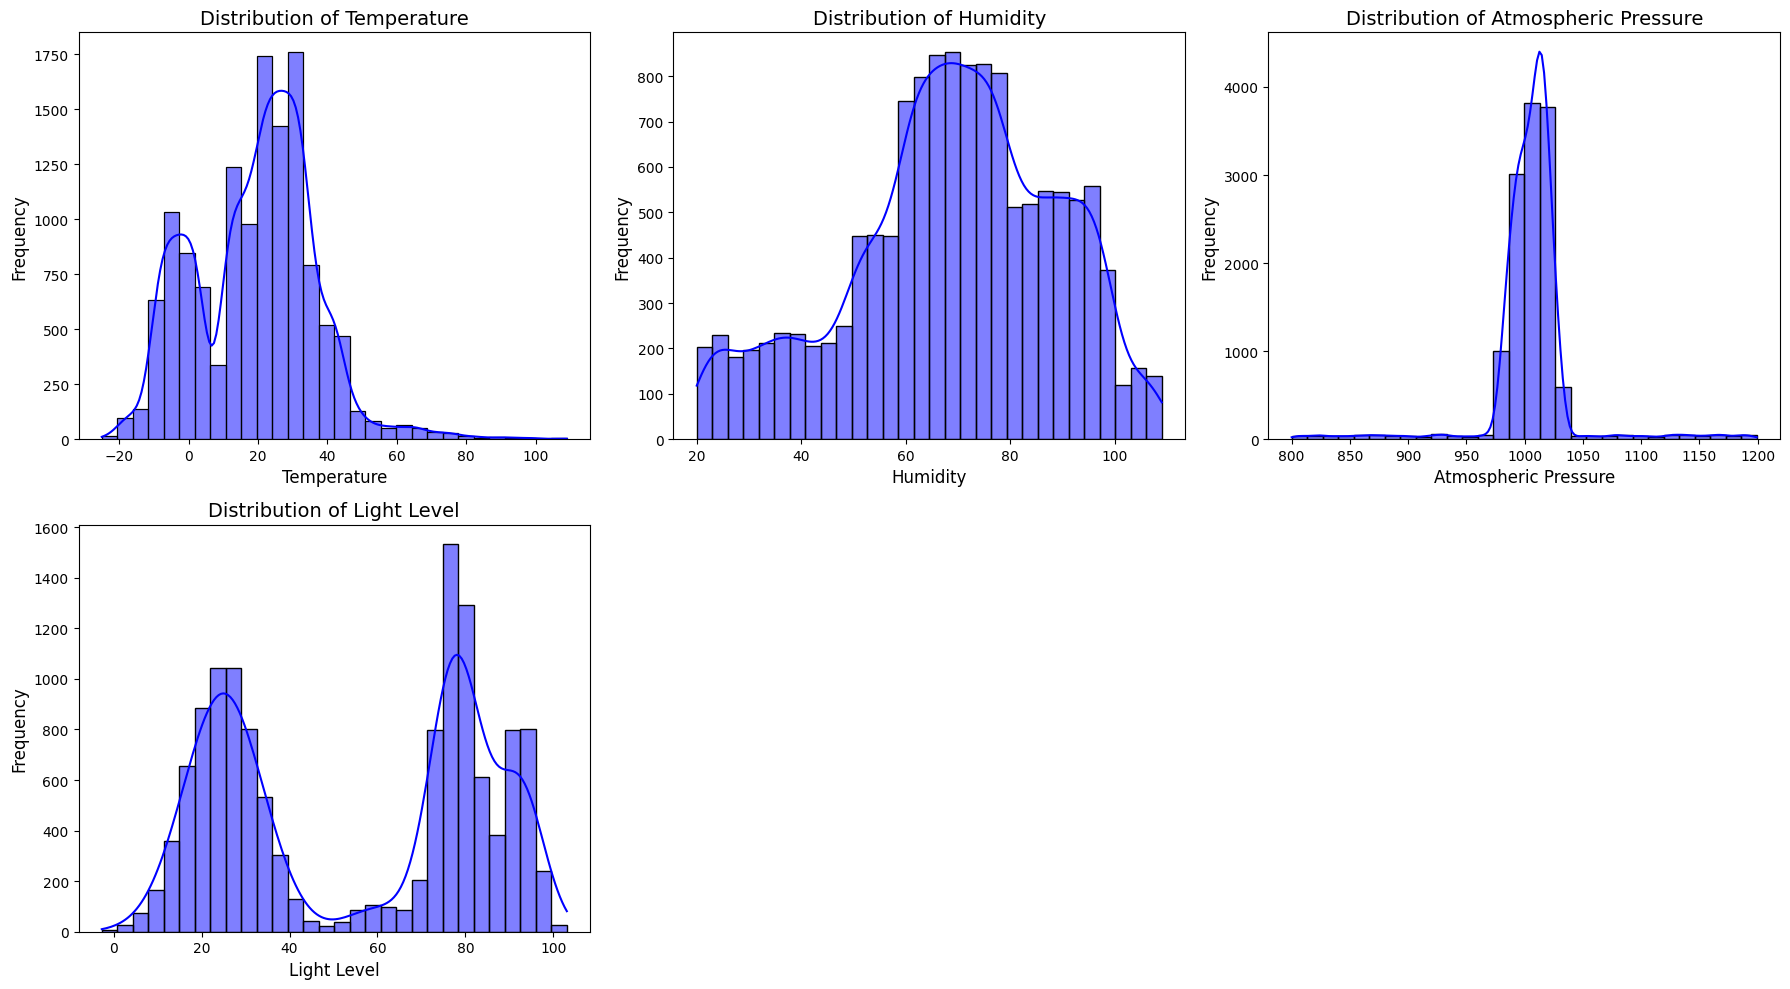

In [127]:
df_features = weather_data.iloc[:, :-1]

# Visualize the distribution of all features except the target - source [1]
def plot_distributions(df, cols_per_row=3):
    num_cols = len(df.columns)
    num_rows = (num_cols // cols_per_row) + int(num_cols % cols_per_row > 0)

    plt.figure(figsize=(cols_per_row * 6, num_rows * 5))

    for i, column in enumerate(df.columns, 1):
        plt.subplot(num_rows, cols_per_row, i)
        sns.histplot(df[column], kde=True, bins=30, color='blue', edgecolor='black')
        plt.title(f"Distribution of {column}", fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.tight_layout()

    plt.show()

plot_distributions(df_features, cols_per_row=3)

# [1] - https://www.kaggle.com/code/amiruluzair/weather-prediction-using-ml-97-accuracy

In [128]:
def handle_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)

    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

numeric_columns = weather_data.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    weather_data = handle_outliers(weather_data, col)

weather_data = weather_data.reset_index(drop=True)

In [129]:
scaler = MinMaxScaler()
weather_data[numeric_columns] = scaler.fit_transform(weather_data[numeric_columns])

encoder = LabelEncoder()
weather_data['Weather Type'] = encoder.fit_transform(weather_data['Weather Type'])

weather_data

,Temperature,Humidity,Atmospheric Pressure,Light Level,Weather Type
0,0.406250,0.595506,0.558921,0.782525,1
1,0.666667,0.853933,0.565866,0.747475,0
2,0.572917,0.494382,0.648867,0.875064,3
3,0.656250,0.707865,0.734601,0.929848,3
4,0.541667,0.606742,0.329500,0.285554,1
...,...,...,...,...,...
12177,0.562500,0.471910,0.467722,0.170715,0
12178,0.364583,0.606742,0.471593,0.170188,1
12179,0.572917,0.640449,0.580212,0.222569,0
12180,0.291667,0.629213,0.256632,0.196568,2


In [130]:
X = weather_data.values[:, :-1]
Y = weather_data.values[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Accuracy - 0.866

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.82      0.77       614
         1.0       0.79      0.73      0.76       607
         2.0       0.98      0.98      0.98       603
         3.0       0.99      0.93      0.96       613

    accuracy                           0.87      2437
   macro avg       0.87      0.87      0.87      2437
weighted avg       0.87      0.87      0.87      2437




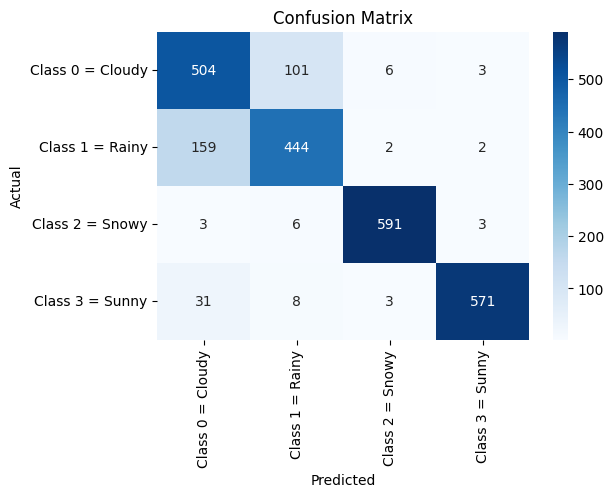

In [131]:
model = RandomForestClassifier(n_estimators=50, random_state=42, criterion='entropy')

# Train the model
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)

# Accuracy
accuracy = model.score(X_test, Y_test)
print()
print(f"Accuracy - {accuracy:.3f}")
print()

# Classification report
print("Classification Report:\n", classification_report(Y_test, Y_pred))
print()

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0 = Cloudy', 'Class 1 = Rainy','Class 2 = Snowy', 'Class 3 = Sunny'], yticklabels=['Class 0 = Cloudy', 'Class 1 = Rainy','Class 2 = Snowy', 'Class 3 = Sunny'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print()

In [132]:
# Save the model and scaler
joblib.dump(model, 'weather_model.pkl')
joblib.dump(scaler, 'weather_scaler.pkl')

['weather_scaler.pkl']